## Importations des modules

In [3]:
# Creation of a random input signal in order to test the operations and the scheme before using directly RedPitaya Card
# and the RedPitaya Python API

import random 
import time 
import numpy as np 
import matplotlib.pyplot as plt 
# import pyqt 
# import os 
# import tqdm
# import pandas as pd 
from simple_pid import PID
import matplotlib.animation as animation
import threading


## Simulation du signal

C:\Users\remyl\AppData\Local\Temp\ipykernel_29048\1535552925.py:91: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, update, interval=interval, blit=True)


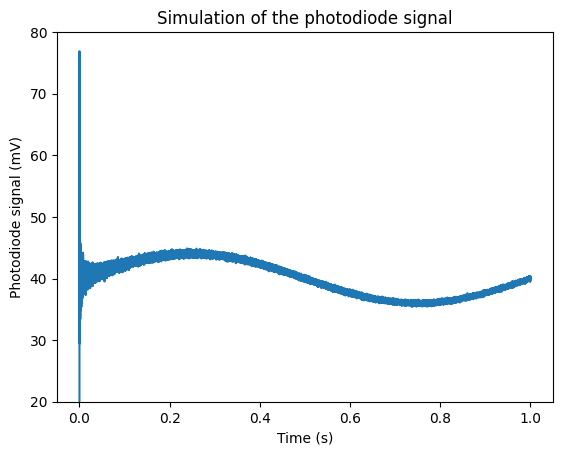

In [15]:
# A first model of the laser power variation is to set the slow variations to be sinusoidal (with small amplitude) and the fast fluctuations 
# to be noise 


# Global variable to control the simulation
simulation_ON = True

def simulate_photodiode_signal(offset, frequency, amplitude, sampling_rate, noise_levels, t):
    """
    Simulate a signal from a photodiode illuminated by a laser, including various types of noise.
    
    Parameters:
    - offset: mean value of the pure photodiode signal 
    - frequency: Frequency of the laser signal (Hz) -> we assume this to be locked by another process (still with slight fluctuations)
    - amplitude of the laser power variations 
    - sampling_rate: Sampling rate (samples per second) of the RedPitaya (depending on the decimation)
    - noise_levels: Dictionary with noise levels for different types of noise
    - t: Time array
    - C: proportionnality coefficient between the Voltage (signal) of the photodiode and the laser power
    
    Returns:
    - signal: Simulated photodiode signal
    """
    signal = (amplitude * np.sin(2 * np.pi * frequency * t) + offset)   # Pure photodiode signal when no fluctuations, proportionnal 
                                                                        # to the mean value of the power of the laser 
    
    # Adding shot noise
    shot_noise = np.random.normal(0, noise_levels['shot'], size=t.shape)
    
    # Adding thermal noise
    thermal_noise = np.random.normal(0, noise_levels['thermal'], size=t.shape)
    
    # Adding amplifier noise
    amplifier_noise = np.random.normal(0, noise_levels['amplifier'], size=t.shape)
    
    # Adding flicker noise (1/f noise)
    flicker_noise = noise_levels['flicker'] * (np.random.normal(0, 1, size=t.shape) / np.sqrt(t + 1e-10))
    
    # Adding dark current noise
    dark_current_noise = np.random.normal(0, noise_levels['dark_current'], size=t.shape)
    
    # Quantization noise
    quantization_levels = noise_levels['quantization']
    quantized_signal = np.round(signal * quantization_levels) / quantization_levels
    quantization_noise = signal - quantized_signal
    
    # Total noisy signal
    signal = (signal + shot_noise + thermal_noise + amplifier_noise +
                    flicker_noise + dark_current_noise + quantization_noise)
    
    return signal

# Parameters
offset  = 40  # mV
frequency = 1  # Hz
amplitude = 4  # mV
duration = 1  # seconds
sampling_rate = 100000  # Hz
interval = 100  # milliseconds between plot updates

# Noise levels for different types of noise
noise_levels = {
    'shot': 0.1,
    'thermal': 0.05,
    'amplifier': 0.03,
    'flicker': 0.1,
    'dark_current': 0.01,
    'quantization': 256  # Number of quantization levels
}

# Time array for one frame
t = np.arange(0, duration, 1/sampling_rate)


# Set up the figure and axis
fig, ax = plt.subplots()
line, = ax.plot(t, np.zeros_like(t))
ax.set_ylim(offset*0.5, offset*2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Photodiode signal (mV)')
ax.set_title('Simulation of the photodiode signal')

def update(frame):
    global simulation_ON
    if simulation_ON:
        signal = simulate_photodiode_signal(offset, frequency, amplitude, sampling_rate, noise_levels, t)
        line.set_ydata(signal)
    return line,

# Create the animation
ani = animation.FuncAnimation(fig, update, interval=interval, blit=True)

# Function to stop the simulation (for testing purposes, will stop after 5 seconds)
def stop_simulation():
    global simulation_ON
    import time
    time.sleep(5)
    simulation_ON = False

# Run the stop_simulation function in a separate thread to simulate stopping the simulation
thread = threading.Thread(target=stop_simulation)
thread.start()

plt.show()


## Analyse du signal

In [ ]:
# Analyse de Fourier du signal + analyse des bruits dans le domaine fréquentiel et temporel -> On pourra donc étudier l'éfficacité
# du processus de locking au niveau des bruits de puissance (RQ importante: dans notre cas on est donc plutôt concerné par 
# les bruits d'amplitude que par les bruits de phase, qui vont induire du bruit de fréquence, auxquels on s'intéresserait si on faisait 
# du frequency locking)

# pour cette section l'article sur les signaux aléatoires de f-legrand m'a beacoup aidé 



## PID Controller


In [2]:
# Variables
kp = 0 
ki = 0  
kd = 0
sp = 0
sample_time = 0.01 # in seconds



# Initialization of the PID object
pid = PID()
pid.sample_time = sample_time  # expressed in seconds
pid.setpoint = sp

# Rk: If the PID is designed to act in reverse mode, then we have to set the following values negative
# All the tunnings should have the same sign
pid.Ki = ki 
pid.Kp = kp
pid.Kd = kd   

# If needed, and to avoid integral windup, it's possible to set a range for 
# the output value of the PID

# pid.output_limits = (0, 10)    # Output value will be between 0 and 10
# pid.output_limits = (0, None)  # Output will always be above 0, but with no upper bound


### Other more advanced features ###

# On-Off possibilities for PID 
# pid.auto_mode = True
# pid.set_auto_mode(True, last_output = 8.0)

# Observe the different components contribution

# by default: differential on measurment (OK)

# Call a function on error signal before to do any computations 

# Override time function, which is time.monotonic() by default

# Last remark: in the case of a simulation, it can be apt to set dt in 
# __call__(input_, dt= None) iff the simulation time is not the same as the real time




input_signal = None

LockON = True
while LockON: 
    output_signal = pid(input_signal)

    input_signal = controlled_system.update(output_signal)


# Reset -> set each item to 0 and clear the integral 
pid.reset()


TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'